In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import datetime
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from sklearn import metrics
from sklearn.utils import shuffle
from skimage import draw
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from skimage.util import pad
import skimage
import time
import tqdm
import math

from tqdm import tqdm_notebook as tqdm 

from Dataset import DataSet,Scale,ToTensor,RandomGaussionBlur,RandomMedianBlur\
,RandomHorizontalFlip,RandomRotation,visualize_loader

import warnings
warnings.filterwarnings('ignore')

from Models import DualEncoding_U_Net, save_model,load_model,init_weights
from Metrics import SoftDiceLoss,dice_metric,MultiClassBCE,SoftDiceLoss,DE_loss
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
    
import pickle



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
png_dir='norm_ideal'
annotation_dir='Annotations'
nucleus_dir='processed_data/nucleus_maps'
boundary_dir='processed_data/boundary_maps'

h_e_train_dir='processed_data/h_e_train_dir'
h_train_dir='processed_data/h_train_dir'
nuclei_mask_train_dir='processed_data/nuclei_mask_train_dir'
boundary_mask_train_dir='processed_data/boundary_mask_train_dir'

h_e_test_dir='processed_data/h_e_test_dir'
h_test_dir='processed_data/h_test_dir'
nuclei_mask_test_dir='processed_data/nuclei_mask_test_dir'
boundary_mask_test_dir='processed_data/boundary_mask_test_dir'

h_e_train_patch_dir='processed_data/h_e_train_patch_dir'
h_train_patch_dir='processed_data/h_train_patch_dir'
nuclei_mask_train_patch_dir='processed_data/nuclei_mask_train_patch_dir'
boundary_mask_train_patch_dir='processed_data/boundary_mask_train_patch_dir'

h_e_test_patch_dir='processed_data/h_e_test_patch_dir'
h_test_patch_dir='processed_data/h_test_patch_dir'
nuclei_mask_test_patch_dir='processed_data/nuclei_mask_test_patch_dir'
boundary_mask_test_patch_dir='processed_data/boundary_mask_test_patch_dir'


In [3]:
train_list=['TCGA-A7-A13E-01Z-00-DX1.png',\
'TCGA-A7-A13F-01Z-00-DX1.png',\
'TCGA-AR-A1AK-01Z-00-DX1.png',\
'TCGA-AR-A1AS-01Z-00-DX1.png',\
'TCGA-18-5592-01Z-00-DX1.png',\
'TCGA-38-6178-01Z-00-DX1.png',\
'TCGA-49-4488-01Z-00-DX1.png',\
'TCGA-50-5931-01Z-00-DX1.png',\
'TCGA-HE-7130-01Z-00-DX1.png',\
'TCGA-HE-7129-01Z-00-DX1.png',\
'TCGA-B0-5711-01Z-00-DX1.png',\
'TCGA-B0-5698-01Z-00-DX1.png',\
'TCGA-G9-6362-01Z-00-DX1.png',\
'TCGA-G9-6336-01Z-00-DX1.png',\
'TCGA-G9-6363-01Z-00-DX1.png',\
'TCGA-G9-6356-01Z-00-DX1.png']

test_list=list(set([x for x in os.listdir(png_dir) if x.split('.')[-1].lower()=='png'])-set(train_list))

# TRAIN

TCGA-A7-A13E-01Z-00-DX1.png<br/>
TCGA-A7-A13F-01Z-00-DX1.png<br/>
TCGA-AR-A1AK-01Z-00-DX1.png<br/>
TCGA-AR-A1AS-01Z-00-DX1.png<br/>
TCGA-18-5592-01Z-00-DX1.png<br/>
TCGA-38-6178-01Z-00-DX1.png<br/>
TCGA-49-4488-01Z-00-DX1.png<br/>
TCGA-50-5931-01Z-00-DX1.png<br/>
TCGA-HE-7130-01Z-00-DX1.png<br/>
TCGA-HE-7129-01Z-00-DX1.png<br/>
TCGA-B0-5711-01Z-00-DX1.png<br/>
TCGA-B0-5698-01Z-00-DX1.png<br/>
TCGA-G9-6362-01Z-00-DX1.png<br/>
TCGA-G9-6336-01Z-00-DX1.png<br/>
TCGA-G9-6363-01Z-00-DX1.png<br/>
TCGA-G9-6356-01Z-00-DX1.png


# TEST

TCGA-E2-A14V-01Z-00-DX1.png<br/>
TCGA-G2-A2EK-01A-02-TSB.png<br/>
TCGA-21-5786-01Z-00-DX1.png<br/>
TCGA-CH-5767-01Z-00-DX1.png<br/>
TCGA-AY-A8YK-01A-01-TS1.png<br/>
TCGA-G9-6348-01Z-00-DX1.png<br/>
TCGA-B0-5710-01Z-00-DX1.png<br/>
TCGA-KB-A93J-01A-01-TS1.png<br/>
TCGA-RD-A8N9-01A-01-TS1.png<br/>
TCGA-21-5784-01Z-00-DX1.png<br/>
TCGA-E2-A1B5-01Z-00-DX1.png<br/>
TCGA-DK-A2I6-01A-01-TS1.png<br/>
TCGA-NH-A8F7-01A-01-TS1.png<br/>
TCGA-HE-7128-01Z-00-DX1.png

196
172


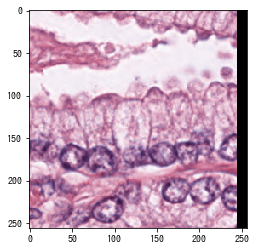

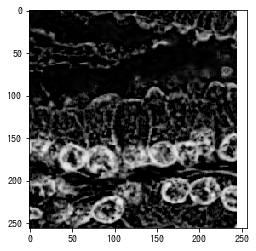

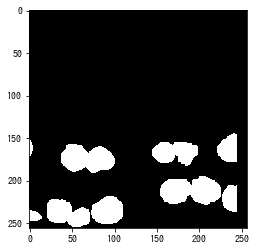

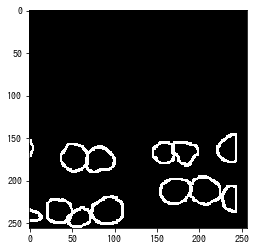

In [4]:
batch_size_train=4
batch_size_test=4
                                                
train_transform=torchvision.transforms.Compose([RandomGaussionBlur(p=0.4,sigma=0.5,truncate=4,apply_dual=False),\
                                                RandomMedianBlur(p=0.4,disk_rad=1),\
                                                RandomHorizontalFlip(p=0.4),\
                                                Scale(),\
                                                ToTensor()])
test_transform=torchvision.transforms.Compose([Scale(),ToTensor()])
train_dataset=DataSet(h_e_train_patch_dir,h_train_patch_dir\
                      ,nuclei_mask_train_patch_dir, boundary_mask_train_patch_dir\
                      ,transform=train_transform,attn_gray=True)
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_dataset=DataSet(h_e_test_patch_dir,h_test_patch_dir\
                      ,nuclei_mask_test_patch_dir, boundary_mask_test_patch_dir\
                      ,transform=test_transform,attn_gray=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=False)

print(train_loader.__len__())
print(test_loader.__len__())
visualize_loader(test_loader,1)

In [5]:
model=DualEncoding_U_Net(img1_ch=3,img2_ch=1,output_ch=1,dropout=0.35)
# model=AttnUNet(img_ch=2,output_ch=1,dropout=0.5)
model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'model_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('{} dir has been made'.format(BEST_MODEL_PATH))
print("Model's state_dict:")
writer = SummaryWriter('{}/experiment_{}'.format(BEST_MODEL_PATH,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/datalab/training-assets/R_medical/atheeth/nuclei_seg/model_2020_01_29 dir has been made
Model's state_dict:
Conv1_encoding_1.conv.0.weight 	 torch.Size([64, 3, 3, 3])
Conv1_encoding_1.conv.0.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.weight 	 torch.Size([64])
Conv1_encoding_1.conv.1.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1_encoding_1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1_encoding_1.conv.3.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.weight 	 torch.Size([64])
Conv1_encoding_1.conv.4.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2_encoding_1.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2_encoding_1.conv.0.bias 	 torch.Size([128])
Conv2_encoding_1.conv.1.we

asm1.W_e1.1.bias 	 torch.Size([1024])
asm1.W_e1.1.running_mean 	 torch.Size([1024])
asm1.W_e1.1.running_var 	 torch.Size([1024])
asm1.W_e1.1.num_batches_tracked 	 torch.Size([])
asm1.W_e2.0.weight 	 torch.Size([1024, 512, 1, 1])
asm1.W_e2.0.bias 	 torch.Size([1024])
asm1.W_e2.1.weight 	 torch.Size([1024])
asm1.W_e2.1.bias 	 torch.Size([1024])
asm1.W_e2.1.running_mean 	 torch.Size([1024])
asm1.W_e2.1.running_var 	 torch.Size([1024])
asm1.W_e2.1.num_batches_tracked 	 torch.Size([])
asm1.psi.0.weight 	 torch.Size([1, 1024, 1, 1])
asm1.psi.0.bias 	 torch.Size([1])
asm1.psi.1.weight 	 torch.Size([1])
asm1.psi.1.bias 	 torch.Size([1])
asm1.psi.1.running_mean 	 torch.Size([1])
asm1.psi.1.running_var 	 torch.Size([1])
asm1.psi.1.num_batches_tracked 	 torch.Size([])
asm1.W_1x1.weight 	 torch.Size([512, 1024, 1, 1])
asm1.W_1x1.bias 	 torch.Size([512])
asm1.batch_norm.weight 	 torch.Size([1024])
asm1.batch_norm.bias 	 torch.Size([1024])
asm1.batch_norm.running_mean 	 torch.Size([1024])
asm1.batch

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
pretrained=True
optimizer_selected='adam'
scheduler_type='reduce_on_plateau'
batchsize=batch_size_train
no_steps=train_dataset.__len__()//batchsize
restart_epochs=8
num_epochs=50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#criterion = SoftDiceLoss()#
criterion=nn.BCELoss()
# criterion=MultiClassBCE(weights=[0.65,0.35])
# criterion=DE_loss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)

if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-04, betas=(0.9, 0.98),weight_decay=0.002)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)


if scheduler_type=='reduce_on_plateau':
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4,\
                                               verbose=True, threshold=0.0001, threshold_mode='rel',\
                                               cooldown=2, min_lr=10e-08, eps=1e-08)
    
else:
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)

if pretrained:
    filename='model_v2_2020_01_28/model_optim.pth'
    load_model(filename,model,optimizer=None,scheduler=None)
else:
    init_weights(model)

best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                
                # get the inputs; data is a list of [dapi, nuclei, boundary]
#                 h_e_train, h_train,nuclei_mask_train,boundary_mask_train = sample_batched['h_e']\
#                 ,sample_batched['h']\
#                 ,sample_batched['nuclei_mask']\
#                 ,sample_batched['boundary_mask']

                h_e_train, h_train,nuclei_mask_train= sample_batched['h_e']\
                ,sample_batched['h']\
                ,sample_batched['nuclei_mask']\
                
                
#                 h_e_train, h_train,nuclei_mask_train,boundary_mask_train = \
#                 h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
#                 ,nuclei_mask_train.to(device, dtype = torch.float)\
#                 ,boundary_mask_train.to(device, dtype = torch.float)
                h_e_train, h_train,nuclei_mask_train= \
                h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                ,nuclei_mask_train.to(device, dtype = torch.float)
                
#                 gt_mask_train=torch.cat((nuclei_mask_train,boundary_mask_train),dim=1)
                gt_mask_train=nuclei_mask_train

                # forward + backward + optimize
#                 img_batch_comb=torch.cat((img_batch,dapi_batch),dim=1)
                outputs = torch.sigmoid(model(h_e_train,h_train))
#                 pred_nuclei_train,pred_boundary_train=torch.chunk(outputs,2,dim=1)
                pred_nuclei_train=outputs
                

                
                loss = criterion(outputs, gt_mask_train)
                dice_score=dice_metric(pred_nuclei_train,nuclei_mask_train)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if (i+1)%50==0:
                    

#                     img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu(),\
#                                          pred_boundary_train.detach().cpu(),boundary_mask_train.detach().cpu()),dim=0)
                    img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu()),dim=0)
                    
                    img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=10)
                    torchvision.utils.save_image\
                    (img_grid2,os.path.join(BEST_MODEL_PATH,\
                                            'train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                    
#                     writer.add_image('TRAIN_ITER_{}'.format(epoch * len(train_loader) + i+1), img_grid2)
                    
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                if scheduler_type!='reduce_on_plateau':
                    scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
                
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
            
            writer.add_scalar('Train dice { epoch }',
                            run_avg_train_dice,
                            epoch+1)
                
            writer.add_scalar('Train loss { epoch }',
                    run_avg_train_loss,
                    epoch * len(train_loader) + i+1)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):
                
#                 h_e_test, h_test,nuclei_mask_test,boundary_mask_test = test_sample['h_e']\
#                 ,test_sample['h']\
#                 ,test_sample['nuclei_mask']\
#                 ,test_sample['boundary_mask']
                
                h_e_test, h_test,nuclei_mask_test= test_sample['h_e']\
                ,test_sample['h']\
                ,test_sample['nuclei_mask']
                
#                 h_e_test, h_test,nuclei_mask_test,boundary_mask_test = \
#                 h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
#                 ,nuclei_mask_test.to(device, dtype = torch.float)\
#                 ,boundary_mask_test.to(device, dtype = torch.float)

                h_e_test, h_test,nuclei_mask_test = \
                h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                ,nuclei_mask_test.to(device, dtype = torch.float)
    
                
                
#                 gt_mask_test=torch.cat((nuclei_mask_test,boundary_mask_test),dim=1)
                gt_mask_test=nuclei_mask_test
    
                test_outputs = torch.sigmoid(model(h_e_test,h_test))
        
#                 pred_nuclei_test,pred_boundary_test=torch.chunk(test_outputs,2,dim=1)
                pred_nuclei_test=test_outputs
    
#                  
                
                test_loss = criterion(test_outputs, gt_mask_test)
                #final_test_loss+=test_loss.detach().item()
                test_dice=dice_metric(pred_nuclei_test,nuclei_mask_test)
                #final_test_dice+=test_dice
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
                
               
                if (j+1)%50==0:
                    
#                     img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu(),\
#                                               pred_boundary_test.detach().cpu(),boundary_mask_test.detach().cpu()),dim=0)
                    
                    img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu()),dim=0)
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid,os.path.join(BEST_MODEL_PATH,\
                                            'test_iter_{}.png'.format(epoch*len(test_loader)+j+1)))
                    
#                     writer.add_image('TEST_ITER_{}'.format(epoch * len(test_loader) + j+1), img_grid)
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            
            writer.add_scalar('Test dice { epoch }',
                            run_avg_test_dice,
                            epoch+1)
                
            writer.add_scalar('Test loss { epoch }',
                    run_avg_test_loss,
                    epoch * len(train_loader) + i+1)
            
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+\
                           '/model_optim.pth',scheduler=scheduler)
                print("saved model with test dice score: {}".format(best_val))
            if scheduler_type=='reduce_on_plateau':
                scheduler.step(run_avg_test_loss)
    
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    

with open("history.txt", "wb") as fp:   #Pickling
    pickle.dump(history, fp)
    
    
    

Tesla V100-SXM2-32GB
Done loading
Learning Rate : 0.0001



test_loss: 0.21424494056538065
test_dice :0.7239138464537039
saved model with test dice score: 0.7239138464537039
Learning Rate : 0.0001



test_loss: 0.21151259690194874
test_dice :0.7218700263267235
Learning Rate : 0.0001



test_loss: 0.21627104713805215
test_dice :0.720087580875909
Learning Rate : 0.0001



test_loss: 0.21399244318609678
test_dice :0.7314574288945025
saved model with test dice score: 0.7314574288945025
Learning Rate : 0.0001



test_loss: 0.21926713028904038
test_dice :0.7315767043335497
saved model with test dice score: 0.7315767043335497
Learning Rate : 0.0001



test_loss: 0.21620087955571415
test_dice :0.7307212931829096
Learning Rate : 0.0001



test_loss: 0.2148907364768327
test_dice :0.7222109774872602
Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
Learning Rate : 1e-05



test_loss: 0.2115445783173929
test_dice :0.7276622998812545
Learning Rate : 1e-05



test_loss: 0.2133755668635296
test_dice :0.7305846907600171
Learning Rate : 1e-05



test_loss: 0.21526635226650254
test_dice :0.7245473624198079
Learning Rate : 1e-05



test_loss: 0.2132947971236117
test_dice :0.7321868039163508
saved model with test dice score: 0.7321868039163508
Learning Rate : 1e-05



test_loss: 0.21573748705554022
test_dice :0.7263839445945307
Learning Rate : 1e-05



test_loss: 0.2125287907350416
test_dice :0.7315612759917156
Learning Rate : 1e-05



test_loss: 0.21733408196248954
test_dice :0.7274460335597439
Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
Learning Rate : 1.0000000000000002e-06



test_loss: 0.21597238284498252
test_dice :0.7291074212346336
Learning Rate : 1.0000000000000002e-06



test_loss: 0.2144041892393994
test_dice :0.7275119049993033
Learning Rate : 1.0000000000000002e-06



test_loss: 0.21425539435664176
test_dice :0.7281320551505833
Learning Rate : 1.0000000000000002e-06



test_loss: 0.2180229235098395
test_dice :0.7280647501021236
Learning Rate : 1.0000000000000002e-06



test_loss: 0.21430835776553234
test_dice :0.7312612460138393
Learning Rate : 1.0000000000000002e-06



test_loss: 0.21422037596110982
test_dice :0.7294580111336635
Learning Rate : 1.0000000000000002e-06



test_loss: 0.21377794549460646
test_dice :0.7287926500128117
Epoch    20: reducing learning rate of group 0 to 1.0000e-07.
Learning Rate : 1.0000000000000002e-07



test_loss: 0.21599885900142776
test_dice :0.7275569559764402
Learning Rate : 1.0000000000000002e-07



test_loss: 0.21487807077887858
test_dice :0.7282803943414079
Learning Rate : 1.0000000000000002e-07



test_loss: 0.21489506150817525
test_dice :0.7269531136879679
Learning Rate : 1.0000000000000002e-07


In [ ]:
# !rm -rf model_2020_01_29